# Analysis of Amazon Review Data:
### - Process data with NLP and calculate distance between reviews based on Bag-of-Words.
### - Apply PCA to obtain and visualize the distance between reviews, and compared with that obtained above.
### - Use Lasso Ordinal Logistic Regression to find factors that influence the overall score of products the most.

In [1]:
import io
import ijson
import pandas as pd
import numpy as np
import datetime
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import FreqDist
import gensim
from gensim.utils import simple_preprocess
import re
from nltk.stem import PorterStemmer
from itertools import chain
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.metrics import r2_score
from mord import LogisticAT
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm._tqdm_notebook import tqdm_notebook
%matplotlib inline
%load_ext autotime
tqdm_notebook.pandas()

C:\Users\lzzse\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Read the data from json file.
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.now()

with open('reviews_electronics.4.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review_df = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

43
time: 44 s


In [3]:
review_df.shape

(494373, 10)

time: 2 ms


In [4]:
review_df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful_start', 'helpful_end',
       'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

time: 2 ms


### 1.Treat each review as a document. Ignore misspellings. Convert all reviews to lowercase. Remove stop words.

In [6]:
review_series = review_df['reviewText']
review_series = review_series.str.lower()

time: 384 ms


In [7]:
# Create list of 
stop_words = stopwords.words('english')
unwanted_stopwords = {"not", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "don't",
                      "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}  
stop_words = [ele for ele in stop_words if ele not in unwanted_stopwords]

time: 7 ms


In [9]:
def sent_to_words(sentence): # Define a function that chop a sentence to words and remove punctuations
    return (gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(sentence): #Define a function to remove stop words.
    word_tokens = sent_to_words(sentence)
    return [w for w in word_tokens if not w in stop_words]

time: 999 µs


In [9]:
filetred_reviews = review_series.apply(lambda x:remove_stopwords(x)) 

time: 2min 15s


### 2. Handle negation: Look for the following two negations: "not" and "xxxn't" (e.g., don't, didn't etc.). Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword".

In [10]:
def negation_idx(filtered_sentence): # Generate list of index contains all negations
    negation_nt = list(filter(lambda x: "n't" in x, filtered_sentence))
    idx_nt = list()
    idx_not = list()
    if len(negation_nt) > 0:
        idx_nt = [i for i, x in enumerate(filtered_sentence) if x in negation_nt]
    
    if 'not' in filtered_sentence:
        idx_not = [i for i, x in enumerate(filtered_sentence) if x == "not"]

    idx_lst  = (idx_nt + idx_not)
    idx_lst.sort()
    return idx_lst


def process_negations(filtered_sentence): # Process the negations
    idx_lst = negation_idx(filtered_sentence) # This list is usually not too long, so it is ok to use for loop
    flag_empty = 0
    if len(idx_lst)==0:
        return filtered_sentence
    else:
        for idx in idx_lst:
            if idx != (len(filtered_sentence)-1):
                if filtered_sentence[idx] != 'not': 
                    filtered_sentence[idx] = filtered_sentence[idx].replace("n't", '')
                    filtered_sentence[idx+1] = 'not_' + filtered_sentence[idx+1]
                else:
                    filtered_sentence[idx] = 'not_' + filtered_sentence[idx+1]
                    filtered_sentence[idx+1] = '' # Just to keep the length, remeber to remove it after done
                    flag_empty = 1
            else:
                if filtered_sentence[idx] != 'not':
                    filtered_sentence[idx] = filtered_sentence[idx].replace("n't", '')
                    filtered_sentence.append("not")

        pocessed_sentence = list(map(lambda x: x.replace("not_not", "not"), filtered_sentence))
        if flag_empty:
            pocessed_sentence.remove("")
        return pocessed_sentence

time: 3 ms


In [11]:
processed_reviews = filetred_reviews.apply(lambda x:process_negations(x)) 

time: 6.52 s


### 3. Stem all words using Porter 1979.

In [12]:
ps = PorterStemmer()
stemmed_reviews = [[ps.stem(word) for word in reivew] for reivew in processed_reviews]

time: 6min 3s


### 4. Create frequency count table for all word stems in all reviews. Use the most frequent 500 words to define the word vector. Create a bag-of-word vector representation for each review in electronics

In [13]:
all_in_one_list = list(chain.from_iterable(stemmed_reviews))
fdist = FreqDist(all_in_one_list)
FreqTable = pd.DataFrame(list(fdist.items()), columns = ["Word","Frequency"])
FreqTable = FreqTable.sort_values(by=['Frequency'],ascending=False)
FreqTable = FreqTable[FreqTable["Word"] != '']

time: 12.6 s


In [32]:
top500 = list(FreqTable.head(500)["Word"])

time: 7 ms


In [34]:
# Create the bag-of-words
sentence_vectors = []
for review_vector in stemmed_reviews:
    sent_vec = []
    for token in top500:
        if token in review_vector:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_array = np.asarray(sentence_vectors) 
bow_df = pd.DataFrame(sentence_array) # transfer the array object to dataframe
bow_df.columns=top500 # rename the dataframe

time: 2min 43s


In [35]:
bow_df.head()

,great,work,good,product,price,excel,nice,qualiti,camera,perfect,...,difficult,combo,ye,network,bose,pair,notebook,dual,easili,found
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 11 ms


### 5. Establish a method for measuring the distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from closest to furthest.

In [71]:
bow_100 = bow_df.iloc[0:100]

time: 1.02 ms


In [ ]:
dist_df = pd.DataFrame(scipy.spatial.distance.cdist(bow_100,bow_100)) # Get the pairwise distance
dist_df = dist_df.where(np.triu(np.ones(dist_df.shape)).astype(np.bool)) # Deduplicate
np.fill_diagonal(dist_df.values, float('nan'))
dist = pd.DataFrame(dist_df.stack().nsmallest(100))
dist.reset_index(inplace=True)
dist.columns = ['ReviewID_1','ReviewID_2','Distance']
pd.set_option('display.max_rows', 100) # Set to display all 100 rows

### 6. Run a PCA and graph the first two PCs for the first 100 reviews. Does your graph reflect your findings from the previous exercise?

In [38]:
# Do the PCA
x = bow_df.head(100)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-1.018714,-0.064134
1,2.198276,0.021004
2,-0.745961,-0.707703
3,0.424188,-0.627911
4,0.155379,-0.885873


time: 54.9 ms


In [ ]:
pc_dist_df = pd.DataFrame(scipy.spatial.distance.cdist(principalDf,principalDf))# Get the pairwise distance between principle components
pc_dist_df = pc_dist_df.where(np.triu(np.ones(pc_dist_df.shape)).astype(np.bool)) # Deduplicate
np.fill_diagonal(pc_dist_df.values, float('nan'))
pc_dist = pd.DataFrame(pc_dist_df.stack().nsmallest(100))
pc_dist.reset_index(inplace=True)
pc_dist.columns = ['ReviewID_1','ReviewID_2','Distance']
pc_dist # Distance between principle components

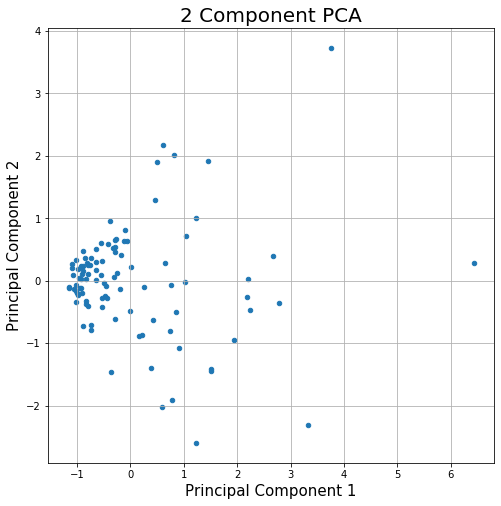

time: 176 ms


In [40]:
# Visualize the result
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'] ,s = 20)
ax.grid()

### 8. Perform a lasso logistic regression and measure the out-of-sample accuracy using ACC .

In [3]:
# Get dataframe for this question
df8 = review_df.dropna()
numeric = ["helpful_start", "helpful_end", "overall", "unixReviewTime"]
df8 = df8[numeric]

time: 212 ms


In [14]:
# Generate bag-of-words dataframe for summary text, repeated what we did for reviewText
summary_series = review_df['summary']
summary_series = summary_series.str.lower()
filetred_summary = summary_series.apply(lambda x:remove_stopwords(x)) 
processed_summary = filetred_summary.apply(lambda x:process_negations(x))
stemmed_summary = [[ps.stem(word) for word in summary] for summary in processed_summary]

all_in_one_list = list(chain.from_iterable(stemmed_summary))
fdist = FreqDist(all_in_one_list)
FreqTable = pd.DataFrame(list(fdist.items()), columns = ["Word","Frequency"])
FreqTable = FreqTable.sort_values(by=['Frequency'],ascending=False)
top50 = list(FreqTable.head(50)["Word"])

# Create the bag-of-words
sentence_vectors = []
for review_vector in stemmed_summary:
    sent_vec = []
    for token in top50:
        if token in review_vector:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_array = np.asarray(sentence_vectors) 
summary_bow_df = pd.DataFrame(sentence_array) # transfer the array object to dataframe
summary_bow_df.columns=top50 # rename the dataframe
summary_bow_df.head(50)

,great,work,good,product,price,excel,nice,qualiti,camera,perfect,...,soni,card,player,amaz,look,ok,replac,bad,gp,job
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 38.5 s


In [15]:
# Append bag of words dataframe
df8 = pd.concat([df8, bow_df], axis=1)
df8 = pd.concat([df8, summary_bow_df], axis=1)
df8 = df8.dropna()

time: 14.2 s


#### Start to build the logistic regression model

In [16]:
# define independent and dependent variables
df8["overall"] = df8["overall"].astype(int)
X = df8.copy()
X = X.drop('overall', 1)
Y = df8.copy()
Y = Y['overall']

# Feature Scaling:
sc_X = StandardScaler()
X_transformed = pd.DataFrame(sc_X.fit_transform(X))
X_transformed.columns = X.columns.values

time: 29.7 s


In [45]:
X_transformed

,helpful_start,helpful_end,unixReviewTime,great,work,good,product,price,excel,nice,...,soni,card,player,amaz,look,ok,replac,bad,gp,job
0,-0.076271,-0.103020,0.952346,1.575169,-0.750526,-0.538432,-0.499976,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
1,0.093398,0.057087,-1.758685,1.575169,1.332399,-0.538432,2.000096,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
2,-0.076271,0.003718,-0.630403,-0.634853,-0.750526,-0.538432,2.000096,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
3,-0.132827,-0.156388,1.356635,1.575169,1.332399,1.857246,-0.499976,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
4,-0.019715,-0.049651,-1.146517,-0.634853,1.332399,-0.538432,2.000096,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494368,-0.132827,-0.156388,0.814716,-0.634853,-0.750526,-0.538432,-0.499976,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
494369,-0.076271,-0.103020,-0.197441,-0.634853,-0.750526,-0.538432,-0.499976,-0.467053,4.263578,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
494370,-0.076271,-0.103020,1.468460,1.575169,1.332399,-0.538432,-0.499976,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695
494371,-0.019715,0.003718,-0.210344,-0.634853,1.332399,-0.538432,-0.499976,-0.467053,-0.234545,-0.318675,...,-0.091177,-0.090464,-0.090725,-0.089194,-0.089837,-0.089711,-0.088998,-0.086184,-0.086446,-0.085695


time: 78.9 ms


In [46]:
def acc_fun(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    return accuracy_score(target_true, target_fit)

acc = make_scorer(acc_fun)
model_ordinal = LogisticAT(alpha=1)
folds = 3
ACC_ordinal = cross_val_score(model_ordinal,
    X_transformed,
    Y,
    cv=folds,
    scoring=acc)
print('Ordinal logistic regression prediction accuracy: ', np.mean(ACC_ordinal))

Ordinal logistic regression prediction accuracy:  0.5664953385399284
time: 1min 40s


### --- 0.5 bonus points if the following methods are run on all reviews (across all the files). Please just continue using the reviews in your assigned file otherwise. ---

### 9. Implement a method to aggregate reviews by product. Can you use any of the other columns to help with aggregation? Explain why or why not. Please clearly explain your method.

In [19]:
model_ordinal = LogisticAT(alpha=1)
model_ordinal.fit(X_transformed.iloc[:,0:503], Y)
coefs = model_ordinal.coef_

time: 38.7 s


In [21]:
review_vector = df8.drop(columns=["overall"]).iloc[:,0:503]

time: 17 s


In [22]:
review_vector

,helpful_start,helpful_end,unixReviewTime,use,work,one,great,get,would,good,...,smaller,via,absolut,caus,ad,local,transfer,limit,goe,someon
0,1.0,1.0,1.365811e+09,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,4.0,1.202429e+09,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3.0,1.270426e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.390176e+09,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2.0,2.0,1.239322e+09,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494368,0.0,0.0,1.357517e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494369,1.0,1.0,1.296518e+09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494370,1.0,1.0,1.396915e+09,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
494371,2.0,3.0,1.295741e+09,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 161 ms


In [95]:
colnames = review_vector.columns
aggregated_vectors = pd.DataFrame()
for i in range(len(coefs)):
    aggregated_vectors[colnames[i]] = review_vector[colnames[i]] * coefs[i]

asins = pd.DataFrame(review_df["asin"])
aggregated_vectors = pd.merge(aggregated_vectors, asins, left_index=True, right_index=True)

time: 5.08 s


In [96]:
colnames = list(aggregated_vectors.columns.values)
colnames.pop(-1)
aggregated_vectors = aggregated_vectors.groupby('asin')[colnames].mean()

time: 3.12 s


In [97]:
asin_index = pd.Series(aggregated_vectors.index.values)

time: 5 ms


In [98]:
# Normalize the vectors
col_names = aggregated_vectors.columns.values
aggregated_vectors = pd.DataFrame(sc_X.fit_transform(aggregated_vectors))
aggregated_vectors.columns = col_names

time: 309 ms


In [101]:
aggregated_vectors = aggregated_vectors.set_index(asin_index)

time: 24 ms


In [102]:
aggregated_vectors

,helpful_start,helpful_end,unixReviewTime,use,work,one,great,get,would,good,...,smaller,via,absolut,caus,ad,local,transfer,limit,goe,someon
0132793040,-0.148747,0.246531,1.287924,-1.008719,0.982558,-0.851806,2.473941,0.721552,0.751201,-0.740229,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,0.195661
B000WW1YVU,10.352659,-9.146051,-0.734015,0.257289,-1.096897,0.079882,1.055712,-0.824206,-0.261706,0.267379,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,-1.460171,0.195661
B000WW1YW4,-0.275707,0.298712,0.250554,-0.024046,0.012146,0.778648,-0.835258,-0.480705,-0.430524,-0.152457,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,-1.778606
B000WW3TLI,0.323213,-0.216292,0.036824,0.275637,0.033242,-0.072024,-0.043928,-0.140936,0.442925,-0.356900,...,-0.271355,-0.174356,-0.192175,0.193618,0.036491,-0.171055,-0.157470,-0.106407,-0.054896,0.195661
B000WW3TM2,0.105173,0.037807,-1.073742,0.960627,0.012146,0.235163,0.267808,-0.480705,0.751201,0.435314,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,0.195661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B001F73YUK,-0.529627,0.559617,2.015644,-1.008719,0.982558,-0.851806,2.473941,0.721552,0.751201,2.786399,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,0.195661
B001F741YI,-0.039924,0.089988,0.004500,-0.375715,-0.265115,-0.153040,0.110227,-0.051327,0.751201,-0.236425,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,3.882557,0.184000,0.197333,0.195661
B001F764Q6,-0.148747,-0.223098,1.557328,-1.008719,0.982558,0.778648,-0.835258,0.721552,0.751201,1.023085,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,0.195661
B001F793O6,0.232133,-0.379641,0.584845,-1.008719,0.982558,-0.851806,-0.835258,0.721552,0.751201,-0.740229,...,0.195546,-0.174356,-0.192175,0.193618,-0.200337,-0.171055,-0.157470,0.184000,0.197333,0.195661


time: 23 ms


### 10. Establish a method for measuring the distance between different products.

In [103]:
# Define a function to calculate the euclidean distance between two products based on their aggregated bag-of-words
def cal_Euclidean_dist(asin1, asin2):
    aggregated_vectors_asin1 = aggregated_vectors.loc[asin1,:]
    aggregated_vectors_asin2 = aggregated_vectors.loc[asin2,:]
    distance = np.linalg.norm(aggregated_vectors_asin1-aggregated_vectors_asin2)
    return distance

time: 1 ms


In [104]:
asins = list(set(review_df["asin"]))

time: 35 ms


In [105]:
# Test on five different product pairs:
dist1 = cal_Euclidean_dist(asins[0],asins[10])
print("The distance between",asins[0], "and", asins[10], "is", dist1)

dist2 = cal_Euclidean_dist(asins[1],asins[10])
print("The distance between",asins[1], "and", asins[10], "is", dist2)

dist3 = cal_Euclidean_dist(asins[2],asins[10])
print("The distance between",asins[2], "and", asins[10], "is", dist3)

dist4 = cal_Euclidean_dist(asins[3],asins[10])
print("The distance between",asins[3], "and", asins[10], "is", dist4)

dist5 = cal_Euclidean_dist(asins[4],asins[10])
print("The distance between",asins[4], "and", asins[10], "is", dist5)

The distance between B0015AHR8W and B001BZI76W is 42.07631138776148
The distance between B00168PU1O and B001BZI76W is 42.28638740240516
The distance between B00139SOZA and B001BZI76W is 37.09783077186564
The distance between B00166ZJ3U and B001BZI76W is 41.199031102273786
The distance between B0013ISYDI and B001BZI76W is 37.928650680629474
time: 33 ms
